<a href="https://colab.research.google.com/github/Deebahz/breast-cancer-detection/blob/main/breastcancerdetectionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


  image_id class severity         x    y radius abnormality
0   REFNUM    BG    CLASS  SEVERITY    X      Y      RADIUS
1   mdb001     G     CIRC         B  535    425         197
2   mdb002     G     CIRC         B  522    280          69
3   mdb003     D     NORM                                  
4   mdb004     D     NORM                                  


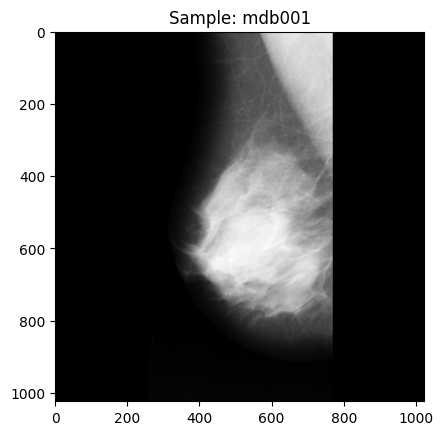

In [ ]:
import os
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Paths
images_dir= "/content/drive/MyDrive/mias/AllPGMs"
info_file = "/content/drive/MyDrive/mias/Info.txt"

# Parse annotations
cols = ["image_id", "class", "severity", "x", "y", "radius", "abnormality"]
df = pd.read_csv(info_file, sep=r"\s+", names=cols, engine="python")

# Replace NaN where no lesion exists
df = df.fillna("")

print(df.head())

# Load one image
sample_id = "mdb001"
img_path = os.path.join(images_dir, f"{sample_id}.pgm")

# Open with PIL
img = Image.open(img_path)
plt.imshow(img, cmap="gray")
plt.title(f"Sample: {sample_id}")
plt.show()

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class MIASDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".pgm")
        img = Image.open(img_path).convert("L")  # grayscale

        if self.transform:
            img = self.transform(img)

        # Assign labels
        label = 0 if row["class"] == "N" else (1 if row["class"] == "B" else 2)
        return img, label

# Example loader
dataset = MIASDataset(df, images_dir, transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Check a batch
for imgs, labels in loader:
    print(imgs.shape, labels)
    break


torch.Size([8, 1, 224, 224]) tensor([2, 2, 2, 2, 2, 2, 2, 2])


In [ ]:
pip install torch torchvision


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Paths
images_dir = "/content/drive/MyDrive/mias/AllPGMs"
info_file = "/content/drive/MyDrive/mias/Info.txt"

# Parse annotations
cols = ["image_id", "class", "severity", "x", "y", "radius", "abnormality"]
df = pd.read_csv(info_file, sep="\s+", names=cols, engine="python")
# Remove the first row as it's part of the header and not an image entry
df = df.iloc[1:].reset_index(drop=True)
df = df.fillna("")


# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset class
class MIASDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".pgm")
        img = Image.open(img_path).convert("L")  # grayscale

        if self.transform:
            img = self.transform(img)

        # Map labels: Normal=0, Benign=1, Malignant=2
        if row["class"] == "N":
            label = 0
        elif row["class"] == "B":
            label = 1
        else:
            label = 2

        return img, label

dataset = MIASDataset(df, images_dir, transform=transform)

# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use pretrained ResNet18
model = models.resnet18(pretrained=True)

# Change input layer (ResNet expects 3 channels, but MIAS is grayscale)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Change output layer (3 classes: Normal, Benign, Malignant)
model.fc = nn.Linear(model.fc.in_features, 3)

model = model.to(device)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Evaluate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total


        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)


Epoch [1/10], Loss: 0.9240, Train Acc: 53.79%, Test Acc: 83.33%
Epoch [2/10], Loss: 0.1183, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [3/10], Loss: 0.0367, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [4/10], Loss: 0.0214, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [5/10], Loss: 0.0153, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [6/10], Loss: 0.0120, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [7/10], Loss: 0.0094, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [8/10], Loss: 0.0083, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [9/10], Loss: 0.0073, Train Acc: 100.00%, Test Acc: 100.00%
Epoch [10/10], Loss: 0.0064, Train Acc: 100.00%, Test Acc: 100.00%


In [ ]:
pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=d3331438f7044102c7522285ae666f8ce739a94d7594ffc40c16aa3da9dd52b4
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Target layer (last convolutional layer in ResNet18)
target_layers = [model.layer4[-1]]

# Grad-CAM object
cam = GradCAM(model=model, target_layers=target_layers)

In [ ]:
def visualize_gradcam(img_tensor, label=None):
    # Convert tensor to numpy (HxWxC), normalize to [0,1]
    img = img_tensor.squeeze().cpu().numpy()
    img_norm = (img - img.min()) / (img.max() - img.min())
    rgb_img = np.stack([img_norm]*3, axis=-1)  # grayscale → RGB

    # Run Grad-CAM
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0).to(device), targets=None)[0]

    # Overlay heatmap
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Show
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rgb_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cam_image)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()


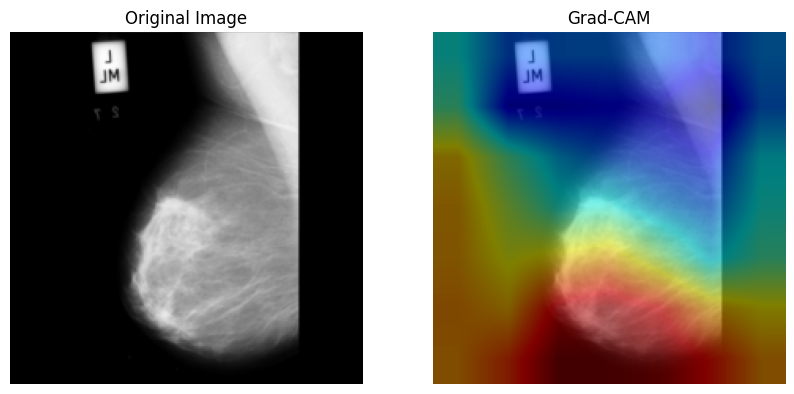

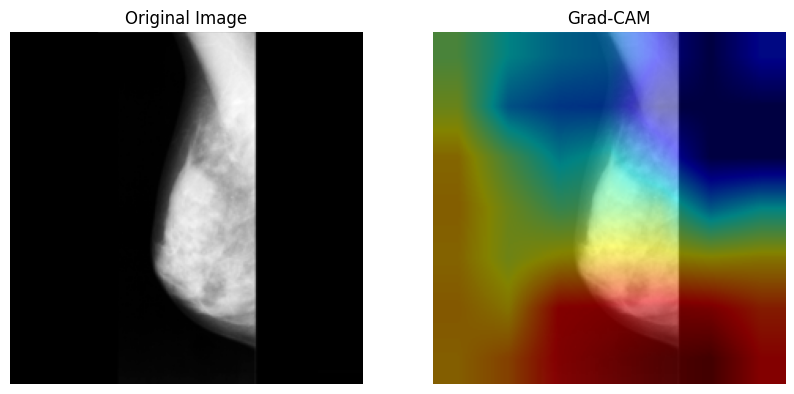

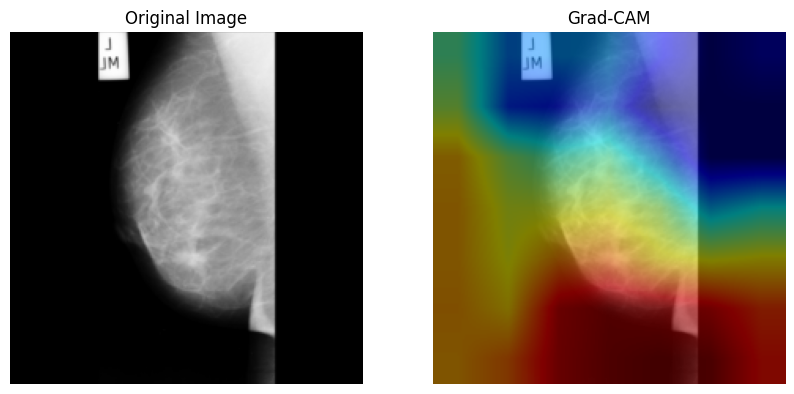

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(8,12))
for i in range(3):
    img = X_test[i].reshape(1,224,224,1)
    heatmap = make_gradcam_heatmap(img, model, "conv2d_1")
    axs[i,0].imshow(X_test[i].reshape(224,224), cmap='gray')
    axs[i,1].imshow(X_test[i].reshape(224,224), cmap='gray')
    axs[i,1].imshow(heatmap, cmap='jet', alpha=0.5)
plt.show()


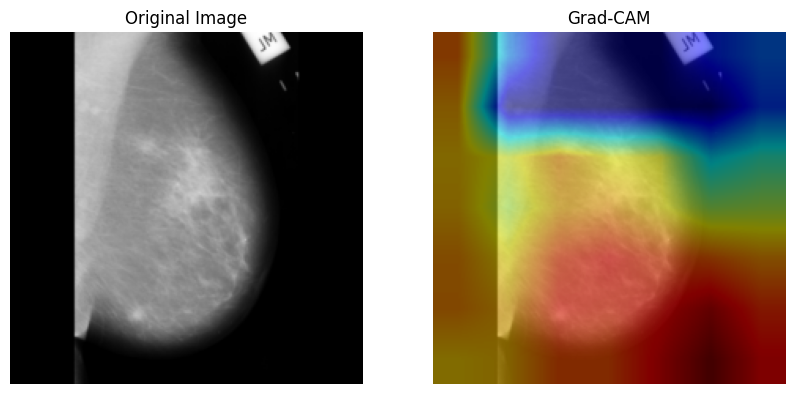

In [ ]:
# Get one test sample
img, label = test_dataset[5]
visualize_gradcam(img, label)


In [ ]:
import torch

# Assuming `model` is your trained CNN
torch.save(model.state_dict(), 'breast_cancer_cnn.pth')


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

def load_model():
    # Define the same modified ResNet18 architecture
    model = models.resnet18(pretrained=False) # No need to load pretrained weights again
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 3)

    # Load the saved state dictionary
    model.load_state_dict(torch.load('breast_cancer_cnn.pth', map_location=torch.device('cpu')))
    model.eval() # Set the model to evaluation mode
    return model

# Example of how to use the loaded model
loaded_model = load_model()
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Load model using the defined load_model function
model = load_model()
model.eval()

# Assuming you have your test set tensors
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move data to the device
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the predicted class index
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        66

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Confusion Matrix:
 [[66]]
